<a href="https://colab.research.google.com/github/sriji1212/mlzoomcamp/blob/main/homework_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Homework 4

Use this notebook as a starter

In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

%matplotlib inline

Data:

- https://github.com/gastonstat/CreditScoring
- Also available [here](https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-06-trees/CreditScoring.csv)

In [ ]:
!wget https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-06-trees/CreditScoring.csv

--2021-10-03 12:15:47--  https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-06-trees/CreditScoring.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 182489 (178K) [text/plain]
Saving to: ‘CreditScoring.csv’

CreditScoring.csv   100%[===================>] 178.21K  --.-KB/s    in 0.02s   

2021-10-03 12:15:48 (10.5 MB/s) - ‘CreditScoring.csv’ saved [182489/182489]



## Preparation 

We'll talk about this dataset in more details in week 6. But for now, use the following code to get started

In [ ]:
df = pd.read_csv('CreditScoring.csv')
df.columns = df.columns.str.lower()

Some of the features are encoded as numbers. Use the following code to de-code them:

In [ ]:
status_values = {
    1: 'ok',
    2: 'default',
    0: 'unk'
}

df.status = df.status.map(status_values)


home_values = {
    1: 'rent',
    2: 'owner',
    3: 'private',
    4: 'ignore',
    5: 'parents',
    6: 'other',
    0: 'unk'
}

df.home = df.home.map(home_values)

marital_values = {
    1: 'single',
    2: 'married',
    3: 'widow',
    4: 'separated',
    5: 'divorced',
    0: 'unk'
}

df.marital = df.marital.map(marital_values)

records_values = {
    1: 'no',
    2: 'yes',
    0: 'unk'
}

df.records = df.records.map(records_values)

job_values = {
    1: 'fixed',
    2: 'partime',
    3: 'freelance',
    4: 'others',
    0: 'unk'
}

df.job = df.job.map(job_values)

Prepare the numerical variables:

In [ ]:
for c in ['income', 'assets', 'debt']:
    df[c] = df[c].replace(to_replace=99999999, value=0)

Remove clients with unknown default status

In [ ]:
df = df[df.status != 'unk'].reset_index(drop=True)

Create the target variable

In [ ]:
df['default'] = (df.status == 'default').astype(int)
del df['status']

## Your code

What are the categorical variables? What are the numerical?

In [ ]:
numerical = ['seniority', 'time', 'age', 'expenses', 'income', 'assets', 'debt', 'amount', 'price']
categorical =  ['home','marital', 'records', 'job']

Split the data into 3 parts: train/validation/test with 60%/20%/20% distribution. Use `train_test_split` funciton for that with `random_state=1`

In [ ]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

## Question 1

ROC AUC could also be used to evaluate feature importance of numerical variables. 

Let's do that

* For each numerical variable, use it as score and compute AUC with the "default" variable
* Use the training dataset for that


If your AUC is < 0.5, invert this variable by putting "-" in front

(e.g. `-df_train['expenses']`)

AUC can go below 0.5 if the variable is negatively correlated with the target varialble. You can change the direction of the correlation by negating this variable - then negative correlation becomes positive.

In [ ]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

In [ ]:
targets = ['seniority', 'time', 'income', 'debt']

for t in targets:
  auc = roc_auc_score(df_train["default"], df_train[t])
  print(t,auc)

seniority 0.2906221375508058
time 0.5608662489595051
income 0.31799333386736695
debt 0.49521703242164505


Which numerical variable (among the following 4) has the highest AUC?

- seniority
- time
- income
- debt

## Training the model

From now on, use these columns only:

```
['seniority', 'income', 'assets', 'records', 'job', 'home']
```

Apply one-hot-encoding using `DictVectorizer` and train the logistic regression with these parameters:

```
LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
```

In [ ]:
numerical = ['seniority', 'income', 'assets']
categorical =  ['home', 'records', 'job']

df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.default.values
y_val = df_val.default.values
y_test = df_test.default.values

del df_train['default']
del df_val['default']
del df_test['default']

dv = DictVectorizer(sparse=False)

train_dict = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
val_dict = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dict)

y_pred = model.predict_proba(X_val)[:, 1]
default_decision = (y_pred > 0.5)
(y_val == default_decision).mean()

0.7800224466891134

In [ ]:
actual_positive = (y_val == 1)
actual_negative = (y_val == 0)

t = 0.5
predict_positive = (y_pred >= t)
predict_negative = (y_pred < t)

tp = (predict_positive & actual_positive).sum()
tn = (predict_negative & actual_negative).sum()

fp = (predict_positive & actual_negative).sum()
fn = (predict_negative & actual_positive).sum()

p = tp / (tp + fp)
r = tp / (tp + fn)


In [ ]:
scores = []

thresholds = np.linspace(0, 1, 101)

for t in thresholds:
  actual_positive = (y_val == 1)
  actual_negative = (y_val == 0)
    
  predict_positive = (y_pred >= t)
  predict_negative = (y_pred < t)

  tp = (predict_positive & actual_positive).sum()
  tn = (predict_negative & actual_negative).sum()

  fp = (predict_positive & actual_negative).sum()
  fn = (predict_negative & actual_positive).sum()
    
  p = tp / (tp + fp)
  r = tp / (tp + fn)
  scores.append((t.round(3), p.round(3), r.round(3)))
  #print((t.round(3), p.round(3), r.round(3)))



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in long_scalars


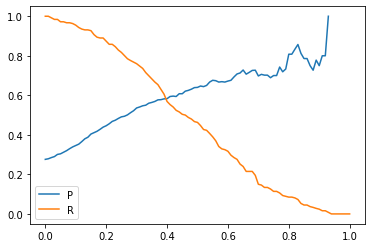

In [ ]:
columns = ['threshold', 'p', 'r']
df_scores = pd.DataFrame(scores, columns=columns)

plt.plot(df_scores.threshold, df_scores['p'], label='P')
plt.plot(df_scores.threshold, df_scores['r'], label='R')
plt.legend()

In [ ]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

In [ ]:
fpr, tpr, thresholds = roc_curve(y_val, y_pred)
auc(fpr, tpr)

0.8120879813449298

## Question 2

What's the AUC of this model on the validation dataset? (round to 3 digits)

- 0.512
- 0.612
- 0.712
- 0.812

## Question 3

Now let's compute precision and recall for our model.

* Evaluate the model on all thresholds from 0.0 to 1.0 with step 0.01
* For each threshold, compute precision and recall
* Plot them

In [ ]:
scores = []

thresholds = np.linspace(0, 1, 101)

for t in thresholds:
  actual_positive = (y_val == 1)
  actual_negative = (y_val == 0)
    
  predict_positive = (y_pred >= t)
  predict_negative = (y_pred < t)

  tp = (predict_positive & actual_positive).sum()
  tn = (predict_negative & actual_negative).sum()

  fp = (predict_positive & actual_negative).sum()
  fn = (predict_negative & actual_positive).sum()
    
  p = tp / (tp + fp)
  r = tp / (tp + fn)
  scores.append((t.round(3), p.round(3), r.round(3)))
  #print((t.round(3), p.round(3), r.round(3)))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in long_scalars


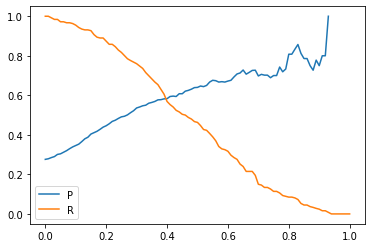

In [ ]:
columns = ['threshold', 'p', 'r']
df_scores = pd.DataFrame(scores, columns=columns)

plt.plot(df_scores.threshold, df_scores['p'], label='P')
plt.plot(df_scores.threshold, df_scores['r'], label='R')
plt.legend()

At which threshold precision and recall curves intersect?

* 0.2
* 0.4
* 0.6
* 0.8

## Question 4

Precision and recall are conflicting - when one grows, the other goes down. That's why they are often combined into the F1 score - a metrics that takes into account both

This is the formula for computing F1:

$$F_1 = 2 \cdot \cfrac{P \cdot R}{P + R}$$

Where $P$ is precision and $R$ is recall.

Let's compute F1 for all thresholds from 0.0 to 1.0 with increment 0.01

In [ ]:
scores = []

thresholds = np.linspace(0, 1, 101)

for t in thresholds:
  actual_positive = (y_val == 1)
  actual_negative = (y_val == 0)
    
  predict_positive = (y_pred >= t)
  predict_negative = (y_pred < t)

  tp = (predict_positive & actual_positive).sum()
  tn = (predict_negative & actual_negative).sum()

  fp = (predict_positive & actual_negative).sum()
  fn = (predict_negative & actual_positive).sum()

  p = tp / (tp + fp)
  r = tp / (tp + fn)

  f1 = 2 * ((p*r) / (p+r))
  scores.append((t.round(2), f1.round(2)))
  #print((t.round(3), p.round(3), r.round(3)))
scores

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in long_scalars


[(0.0, 0.43),
 (0.01, 0.44),
 (0.02, 0.44),
 (0.03, 0.45),
 (0.04, 0.46),
 (0.05, 0.46),
 (0.06, 0.47),
 (0.07, 0.48),
 (0.08, 0.49),
 (0.09, 0.5),
 (0.1, 0.51),
 (0.11, 0.51),
 (0.12, 0.53),
 (0.13, 0.54),
 (0.14, 0.55),
 (0.15, 0.56),
 (0.16, 0.57),
 (0.17, 0.57),
 (0.18, 0.58),
 (0.19, 0.59),
 (0.2, 0.59),
 (0.21, 0.6),
 (0.22, 0.61),
 (0.23, 0.61),
 (0.24, 0.61),
 (0.25, 0.61),
 (0.26, 0.61),
 (0.27, 0.61),
 (0.28, 0.62),
 (0.29, 0.62),
 (0.3, 0.63),
 (0.31, 0.63),
 (0.32, 0.63),
 (0.33, 0.62),
 (0.34, 0.62),
 (0.35, 0.62),
 (0.36, 0.61),
 (0.37, 0.61),
 (0.38, 0.6),
 (0.39, 0.59),
 (0.4, 0.58),
 (0.41, 0.57),
 (0.42, 0.57),
 (0.43, 0.56),
 (0.44, 0.56),
 (0.45, 0.55),
 (0.46, 0.55),
 (0.47, 0.55),
 (0.48, 0.55),
 (0.49, 0.54),
 (0.5, 0.54),
 (0.51, 0.53),
 (0.52, 0.51),
 (0.53, 0.51),
 (0.54, 0.51),
 (0.55, 0.49),
 (0.56, 0.48),
 (0.57, 0.45),
 (0.58, 0.44),
 (0.59, 0.44),
 (0.6, 0.43),
 (0.61, 0.41),
 (0.62, 0.4),
 (0.63, 0.4),
 (0.64, 0.37),
 (0.65, 0.36),
 (0.66, 0.33),
 (0.67,

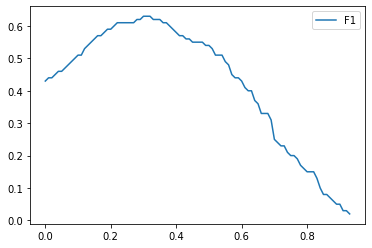

In [ ]:
columns = ['threshold', 'f1']
df_scores = pd.DataFrame(scores, columns=columns)

plt.plot(df_scores.threshold, df_scores['f1'], label='F1')
plt.legend()

At which threshold F1 is maximal?

- 0.1
- 0.3
- 0.5
- 0.7

## Question 5


Use the `KFold` class from Scikit-Learn to evaluate our model on 5 different folds:

```
KFold(n_splits=5, shuffle=True, random_state=1)
```

* Iterate over different folds of `df_full_train`
* Split the data into train and validation
* Train the model on train with these parameters: `LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)`
* Use AUC to evaluate the model on validation


In [ ]:
def train(df_train, y_train, C=1.0):
    dicts = df_train[categorical + numerical].to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
    model.fit(X_train, y_train)
    
    return dv, model

def predict(df, dv, model):
    dicts = df[categorical + numerical].to_dict(orient='records')

    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

In [ ]:
from sklearn.model_selection import KFold
!pip install tqdm

In [ ]:
from tqdm.auto import tqdm
from sklearn.metrics import roc_auc_score

In [ ]:
n_splits = 5

for C in tqdm([0.001, 0.01, 0.1, 0.5, 1, 5, 10]):
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)

    scores = []

    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        y_train = df_train.default.values
        y_val = df_val.default.values

        dv, model = train(df_train, y_train, C=C)
        y_pred = predict(df_val, dv, model)

        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)

    print('C=%s %.3f +- %.3f' % (C, np.mean(scores), np.std(scores)))

  0%|          | 0/7 [00:00<?, ?it/s]

C=0.001 0.767 +- 0.007
C=0.01 0.808 +- 0.012
C=0.1 0.813 +- 0.014
C=0.5 0.814 +- 0.015
C=1 0.812 +- 0.014
C=5 0.814 +- 0.015
C=10 0.814 +- 0.015


How large is standard devidation of the scores across different folds?

- 0.001
- 0.014
- 0.09
- 0.14

## Question 6

Now let's use 5-Fold cross-validation to find the best parameter C

* Iterate over the following C values: `[0.01, 0.1, 1, 10]`
* Initialize `KFold` with the same parameters as previously
* Use these parametes for the model: `LogisticRegression(solver='liblinear', C=C, max_iter=1000)`
* Compute the mean score as well as the std (round the mean and std to 3 decimal digits)

[0.8255915255915256,
 0.825427566891127,
 0.7892586687923474,
 0.8249125496207208,
 0.8055263879823291]

Which C leads to the best mean score?

- 0.01
- 0.1
- 1
- 10

If you have ties, select the score with the lowest std. If you still have ties, select the smallest C

## Submit the results

Submit your results here: https://forms.gle/e497sR5iB36mM9Cs5

It's possible that your answers won't match exactly. If it's the case, select the closest one.

## Deadline

The deadline for submitting is 04 October 2021, 17:00 CET. After that, the form will be closed.